
# Data Encoding in QML — Practice Notebook

**Goal.** Hands-on practice with *data encoding* for Quantum Machine Learning (QML), using only the code patterns shown in the lesson:
- Basis encoding
- Amplitude encoding
- Angle encoding
- Phase encoding
- Dense angle encoding
- Built-in feature maps: `efficient_su2`, `z_feature_map`, `zz_feature_map`, `pauli_feature_map`

Each section contains: a short explanation, a runnable example, and **Your turn** mini-exercises.



> **Note.** This notebook uses Qiskit 1.x style imports shown in the lesson.  
> If you run into import errors locally, ensure your environment matches the versions you installed.


## Notation

**Dataset.** Let $X=\{\mathbf{x}^{(j)}\}_{j=1}^M$ with each $\mathbf{x}^{(j)}\in\mathbb{R}^N$.  
We use $\Phi(\mathbf{x})$ for a generic ML feature map and $U(\mathbf{x})$ for its quantum-circuit unitary.

- We will usually load **one** vector $\mathbf{x}\in\mathbb{R}^N$ at a time.  
- In QML, **normalization** matters:  
  - Classical min–max normalization rescales each feature column.  
  - Quantum states must satisfy $\|\psi\|^2=\langle\psi|\psi\rangle=1$.  
    E.g., in **amplitude encoding** we rescale so that $\sum_i |x_i|^2=1$.  
  - In **angle/phase** encodings we typically rescale features to $(0,2\pi]$ to avoid modulo-$2\pi$ information loss.

We will also use a small example dataset:  

$$
X_{\rm ex}=\{(4,8,5),(9,8,6),(2,9,2),(5,7,0),(3,7,5)\},
$$

and frequently the single vector $\mathbf{x}^{(1)}=(4,8,5)$.


In [1]:
# Common imports used in the examples below (pulled from the lesson)
from math import pi
import math
import numpy as np

# Qiskit core utilities used in the lesson
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Visualization helpers used in the lesson
from qiskit.visualization.bloch import Bloch
from qiskit.visualization.state_visualization import _bloch_multivector_data

# Built-in feature maps used in the lesson
from qiskit.circuit.library import efficient_su2, z_feature_map, zz_feature_map, pauli_feature_map

# Matplotlib for a few plots (also from the lesson gallery)
import matplotlib.pyplot as plt



### Helper: Bloch-sphere visualizer

The following function is the same helper used in the lesson. It plots a sequence of single-qubit states on a single Bloch sphere to visualize rotations.


In [3]:
def plot_Nstates(states, axis=None, plot_trace_points=True):
    """Plot N Statevector objects on one Bloch sphere (from the lesson)."""
    bloch_vecs = [_bloch_multivector_data(s)[0] for s in states]

    if axis is None:
        bloch_plot = Bloch()
    else:
        bloch_plot = Bloch(axes=axis)

    bloch_plot.add_vectors(bloch_vecs)

    if len(states) > 1:
        def rgba_map(x, num):
            g = (0.95 - 0.05) / (num - 1)
            i = 0.95 - g * num
            y = g * x + i
            return (0.0, y, 0.0, 0.7)

        num = len(states)
        bloch_plot.vector_color = [rgba_map(x, num) for x in range(1, num + 1)]

    bloch_plot.vector_width = 3
    bloch_plot.vector_style = "simple"

    if plot_trace_points:
        def trace_points(bloch_vec1, bloch_vec2):
            n_points = 15
            thetas = np.arccos([bloch_vec1[2], bloch_vec2[2]])
            phis = np.arctan2([bloch_vec1[1], bloch_vec2[1]], [bloch_vec1[0], bloch_vec2[0]])
            if phis[1] < 0:
                phis[1] = phis[1] + 2 * pi
            angles0 = np.linspace(phis[0], phis[1], n_points)
            angles1 = np.linspace(thetas[0], thetas[1], n_points)

            xp = np.cos(angles0) * np.sin(angles1)
            yp = np.sin(angles0) * np.sin(angles1)
            zp = np.cos(angles1)
            pnts = [xp, yp, zp]
            bloch_plot.add_points(pnts)
            bloch_plot.point_color = "k"
            bloch_plot.point_size = [4] * len(bloch_plot.points)
            bloch_plot.point_marker = ["o"]

        for i in range(len(bloch_vecs) - 1):
            trace_points(bloch_vecs[i], bloch_vecs[i + 1])

    bloch_plot.sphere_alpha = 0.05
    bloch_plot.frame_alpha = 0.15
    bloch_plot.figsize = [4, 4]
    bloch_plot.render()


## 1) Basis Encoding

**Idea.** Encode a classical $P$-bit string into a computational basis state of a $P$-qubit system.  
For $(b_1, \dots, b_P) \in \{0,1\}^P$, the quantum state is:

$$
|x\rangle = |b_1, b_2, \dots, b_P\rangle.
$$

Each classical bit maps directly to one qubit  
($0 \rightarrow |0\rangle$, $1 \rightarrow |1\rangle$),  
so the binary structure of data is preserved exactly.

---

**Example.** Encode $(5,7,0)$ with 4 bits per feature:  

$$
5 \to (0101), \quad
7 \to (0111), \quad
0 \to (0000),
$$

giving the 12-qubit state  

$$
|010101110000\rangle.
$$

Each feature uses a distinct group of qubits,  
so $(5,7,0)$ becomes a structured quantum basis state.


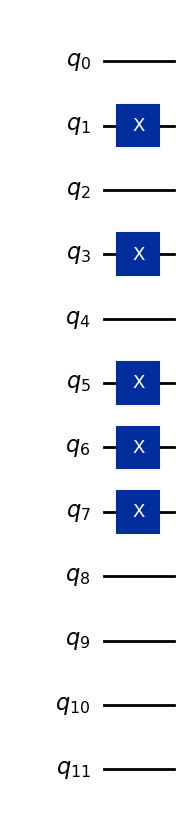

In [4]:
# Example code from the lesson, generalized to (5,7,0)
x = 5  # 0101
y = 7  # 0111
z = 0  # 0000

x_bits = [int(b) for b in format(x, "04b")]
y_bits = [int(b) for b in format(y, "04b")]
z_bits = [int(b) for b in format(z, "04b")]
all_bits = x_bits + y_bits + z_bits

qc_basis = QuantumCircuit(12)
for idx, bit in enumerate(all_bits):
    if bit == 1:
        qc_basis.x(idx)

qc_basis.draw("mpl")


**Your turn.** Encode $\mathbf{x}^{(1)}=(4,8,5)$ using 4 bits per feature.

- Write code to build the corresponding quantum circuit with $12$ qubits.  
- Hint: follow the exact pattern above (format to 4-bit binary, append, apply `x` on 1s).


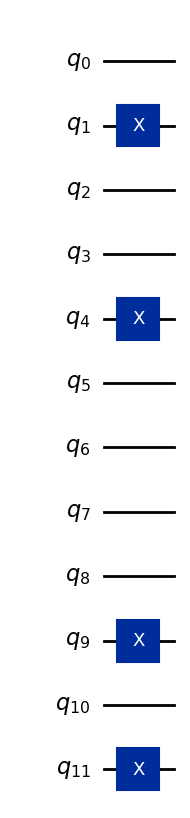

In [5]:
# TODO: Implement basis encoding for (4,8,5) using exactly the same pattern.
a, b, c = 4, 8, 5

a_bits = [int(bit) for bit in format(a, "04b")]
b_bits = [int(bit) for bit in format(b, "04b")]
c_bits = [int(bit) for bit in format(c, "04b")]

all_bits_485 = a_bits + b_bits + c_bits

qc_485 = QuantumCircuit(12)
for i, bit in enumerate(all_bits_485):
    if bit == 1:
        qc_485.x(i)

qc_485.draw("mpl")


## 2) Amplitude Encoding

**Idea.** Encode a normalized vector $\mathbf{x} = (x_1, \dots, x_N)$ into the amplitudes of a quantum state:

$$
|\psi_{\mathbf{x}}\rangle = \frac{1}{\alpha}\sum_{i=1}^{N} x_i |i\rangle, \qquad
\sum_{i=1}^{N} |x_i|^2 = |\alpha|^2.
$$

A system of $n$ qubits can represent $2^n$ complex amplitudes.  
Therefore, choose $n$ so that $2^n \ge N$.  
If $N$ is not a power of two, **pad with zeros** until the length is $2^n$.

---

**Example.**  
Let $\mathbf{x} = (4, 8, 5)$.  
Its normalized version is:

$$
\frac{1}{\sqrt{4^2 + 8^2 + 5^2}}(4, 8, 5, 0)
  = \left(\frac{4}{\sqrt{105}}, \frac{8}{\sqrt{105}}, \frac{5}{\sqrt{105}}, 0\right).
$$

Since $N=3 < 4 = 2^2$, we use 2 qubits to represent these 4 amplitudes.

Amplitude encoding stores all values **simultaneously** in one quantum state,  
but preparing such states can be **computationally expensive** for large $n$.


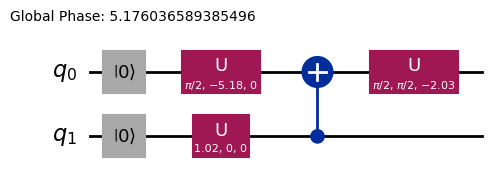

In [12]:
# Example from the lesson: encode (4,8,5) on 2 qubits (pad with a zero)
desired_state = [
    4 / math.sqrt(105),
    8 / math.sqrt(105),
    5 / math.sqrt(105),
    0 / math.sqrt(105),
]

qc_amp = QuantumCircuit(2)
qc_amp.initialize(desired_state, [0, 1])
qc_amp.decompose(reps=5).draw(output="mpl")


**Your turn A.** Normalize and write the state $|\psi_{\mathbf{x}}\rangle$ for $\mathbf{x}=(9,8,6,2,9,2)$.  
*(Just compute the normalization constant and list the amplitudes; you can print them.)*

**Your turn B.** Build a circuit using `initialize` that loads the normalized amplitudes for $\mathbf{x}=(9,8,6,2,9,2)$.  
- Choose $n$ with $2^n \ge 6$ and **pad with zeros** to length $2^n$.


Norm alpha = 16.431676725154983
Amplitudes (length 6) = [0.5477225575051662, 0.48686449556014766, 0.36514837167011077, 0.12171612389003691, 0.5477225575051662, 0.12171612389003691]


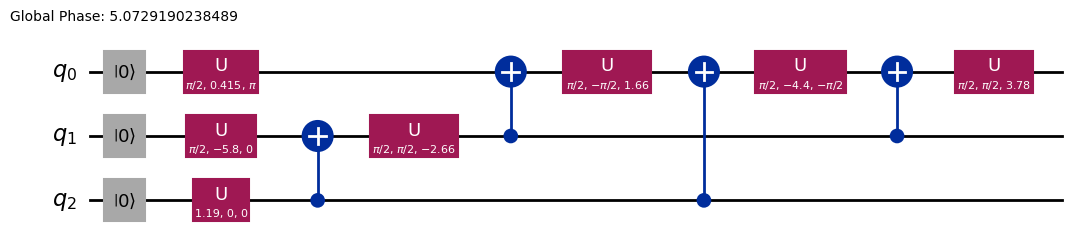

In [7]:
# Your turn A: compute normalized amplitudes for x=(9,8,6,2,9,2)
x = np.array([9,8,6,2,9,2], dtype=float)
alpha = np.linalg.norm(x)
amps = (x / alpha).tolist()
print("Norm alpha =", alpha)
print("Amplitudes (length 6) =", amps)

# Your turn B: choose n with 2^n >= 6 -> n=3, length=8, pad with zeros
amps_padded = amps + [0.0, 0.0]  # pad to length 8
qc_amp2 = QuantumCircuit(3)
qc_amp2.initialize(amps_padded, [0,1,2])
qc_amp2.decompose(reps=5).draw("mpl")


**Your turn C.** Automate amplitude encoding:  
Write a helper that takes any real vector $\mathbf{x}$ and returns a circuit that  
1) normalizes $\mathbf{x}$, 2) pads to length $2^n$, and 3) calls `initialize`.  
Use it for $\mathbf{x}=(4,8,5,9,8,6,2,9,2,5,7,0,3,7,5)$.


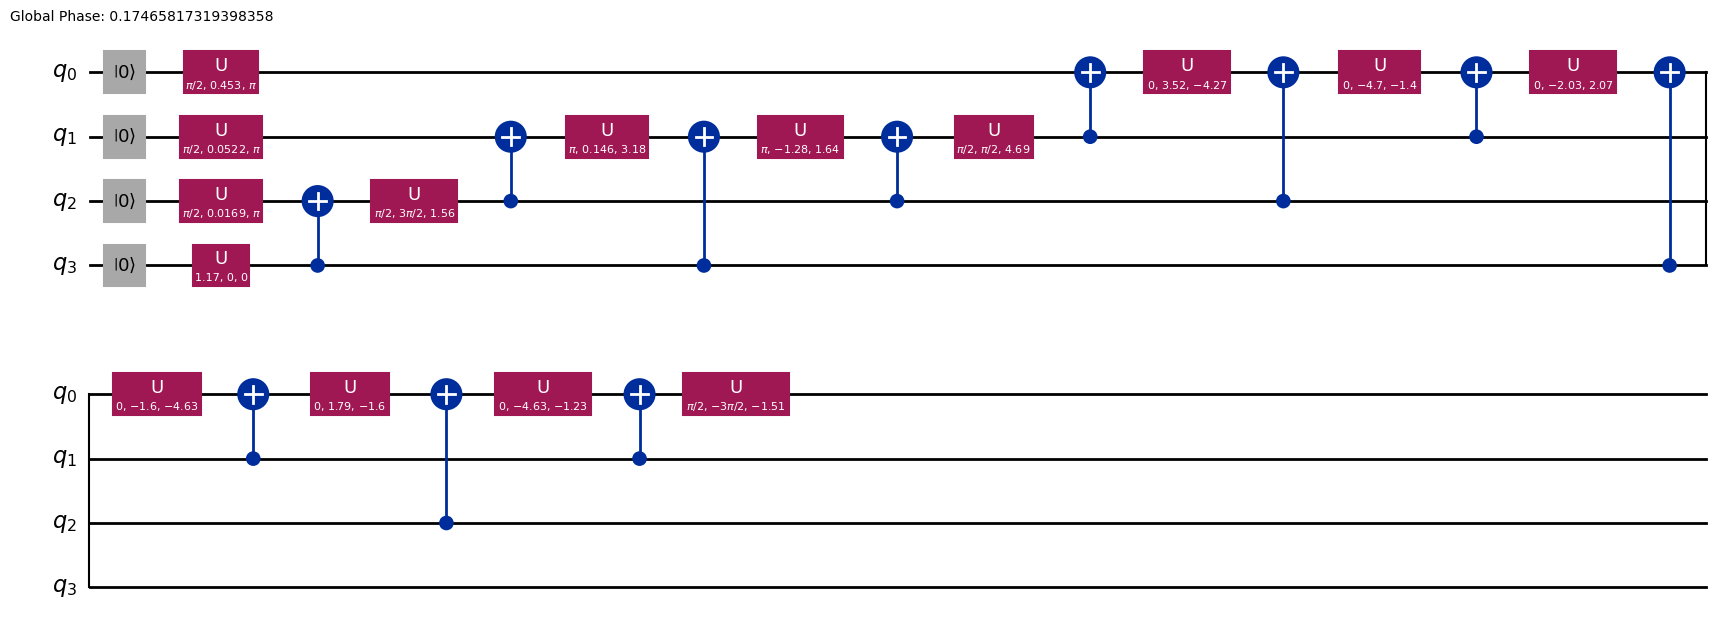

In [8]:
def amplitude_encode(vec):
    vec = np.array(vec, dtype=float)
    alpha = np.linalg.norm(vec)
    if alpha == 0:
        raise ValueError("Zero vector cannot be amplitude-encoded.")
    amps = (vec / alpha).tolist()

    # pad to power of two
    length = 1
    while length < len(amps):
        length *= 2
    amps = amps + [0.0] * (length - len(amps))

    n_qubits = int(math.log2(length))
    qc = QuantumCircuit(n_qubits)
    qc.initialize(amps, list(range(n_qubits)))
    return qc

vec_long = [4,8,5,9,8,6,2,9,2,5,7,0,3,7,5]
qc_amp_long = amplitude_encode(vec_long)
qc_amp_long.decompose(reps=5).draw("mpl")


## 3) Angle Encoding (Y-axis)

**Idea.** Map each feature value to a rotation angle of $R_Y(\theta)$ on one qubit:

$$
|x_k\rangle = R_Y(\theta = x_k)|0\rangle
= \cos\!\left(\tfrac{x_k}{2}\right)|0\rangle + \sin\!\left(\tfrac{x_k}{2}\right)|1\rangle.
$$

Each feature is stored as a **rotation around the Y-axis**, producing a product state across qubits.  
Because rotation angles are periodic, features should be **rescaled to $(0, 2\pi]$** to preserve relative variation.

---

**Example.**  
If $x = \tfrac{\pi}{2}$, then:

$$
R_Y\!\left(\tfrac{\pi}{2}\right)|0\rangle
= \tfrac{1}{\sqrt{2}}(|0\rangle + |1\rangle),
$$

which places the qubit on the equator of the Bloch sphere.

Angle encoding is easy to implement and hardware-efficient,  
making it a common choice in quantum machine learning circuits.


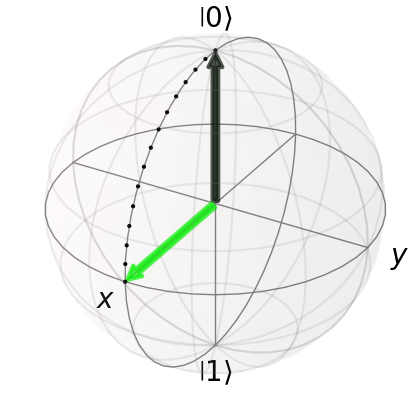

In [9]:
qc = QuantumCircuit(1)
state_before = Statevector.from_instruction(qc)
qc.ry(pi/2, 0)          # encode theta = pi/2
state_after = Statevector.from_instruction(qc)
plot_Nstates((state_before, state_after), axis=None, plot_trace_points=True)


**Your turn.** Encode $\mathbf{x}=(0,\pi/4,\pi/2)$ using angle encoding on three qubits (depth $\approx 1$ before transpilation).  
- Build a circuit with `ry(2*x_k)` or `ry(x_k)` consistently with the formula above.


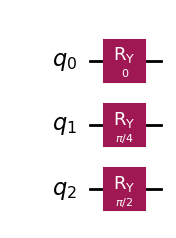

In [19]:
# Encode x=(0, pi/4, pi/2) as Y-rotations on 3 qubits
x = [0.0, pi/4, pi/2]
qc_angle = QuantumCircuit(3)
for q, val in enumerate(x):
    qc_angle.ry(val, q)   # RY(theta=x_k) per the section's convention
qc_angle.draw("mpl")


## 4) Phase Encoding (Z-axis)

**Idea.** Initialize each qubit in the superposition state $|+\rangle = H|0\rangle$,  
then apply a phase rotation $P(\phi) = e^{i\phi/2} R_Z(\phi)$:

$$
|x_k\rangle = P(\phi = x_k)|+\rangle
= \tfrac{1}{\sqrt{2}}\big(|0\rangle + e^{i x_k}|1\rangle\big).
$$

Each feature controls the **relative phase** between $|0\rangle$ and $|1\rangle$,  
while the amplitude remains unchanged.  
Thus, the encoded information appears as interference effects during later operations.

As with angle encoding, the state is separable across qubits (a **product state**),  
so features should be **rescaled to $(0, 2\pi]$** to preserve their distinctiveness.


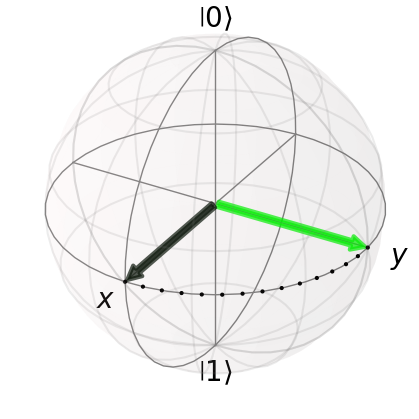

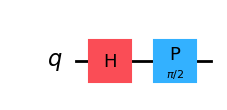

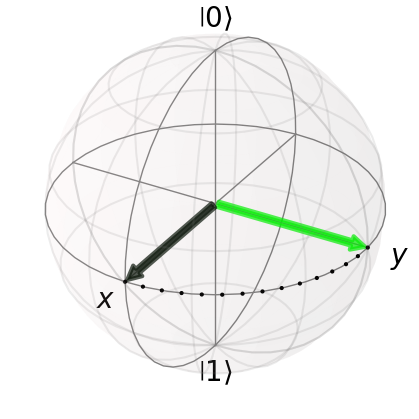

In [13]:
qc = QuantumCircuit(1)
qc.h(0)
state1 = Statevector.from_instruction(qc)
qc.p(pi/2, 0)  # encode phi = pi/2
state2 = Statevector.from_instruction(qc)
plot_Nstates((state1, state2), axis=None, plot_trace_points=True)
qc.draw("mpl", scale=1)


**Your turn A.** How many qubits are needed to phase-encode 8 features? *(Answer in a markdown cell below.)*

**Your turn B.** Phase-encode $\mathbf{x}=(4,8,5,9,8,6,2,9,2,5,7,0)$  
(treat numbers as raw angles; in practice rescale to $(0, 2\pi]$).


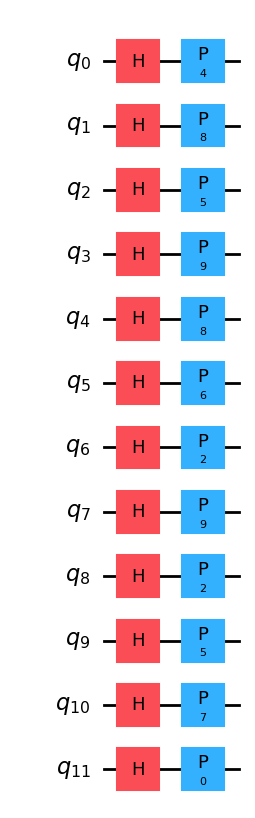

In [14]:
# Phase-encode a length-12 vector (here directly used as angles for demonstration)
x = [4,8,5,9,8,6,2,9,2,5,7,0]
qc_phase = QuantumCircuit(len(x))
for q, val in enumerate(x):
    qc_phase.h(q)
    qc_phase.p(val, q)
qc_phase.draw("mpl", scale=1)


## 5) Dense Angle Encoding (DAE)

**Idea.** Encode **two** features onto **one** qubit:  
apply first a rotation around the Y-axis, then a rotation around the Z-axis:

$$
|x_{2k-1}, x_{2k}\rangle
= R_Z(\phi = x_{2k})\,R_Y(\theta = x_{2k-1})\,|0\rangle
= \cos\!\left(\tfrac{\theta}{2}\right)|0\rangle
+ e^{i\phi}\sin\!\left(\tfrac{\theta}{2}\right)|1\rangle.
$$

This method combines both **magnitude** (through $R_Y$) and **phase** (through $R_Z$) information  
on the same qubit, allowing more compact feature representation.

Hence, encoding $N$ features requires only $\lceil N/2 \rceil$ qubits.  
DAE is useful when qubit resources are limited while moderate feature density is desired.


In [ ]:
# Demo: theta=3*pi/8, phi=7*pi/4 on one qubit, visualized
qc = QuantumCircuit(1)
s0 = Statevector.from_instruction(qc)
qc.ry(3*pi/8, 0)
s1 = Statevector.from_instruction(qc)
qc.rz(7*pi/4, 0)
s2 = Statevector.from_instruction(qc)
plot_Nstates((s0, s1, s2), axis=None, plot_trace_points=True)


**Your turn.** DAE-encode $\mathbf{x}=(4,8,5,9,8,6,2,9,2,5,7,0,3,7,5)$.  
- Use one qubit per pair $(x_{2k-1}, x_{2k})$: apply `ry(x_{2k-1})` then `rz(x_{2k})`.


In [ ]:
x = [4,8,5,9,8,6,2,9,2,5,7,0,3,7,5]
n_qubits = (len(x)+1)//2
qc_dae = QuantumCircuit(n_qubits)
for k in range(n_qubits):
    theta = x[2*k]
    phi   = x[2*k+1] if 2*k+1 < len(x) else 0.0  # pad last phi if odd length
    qc_dae.ry(theta, k)
    qc_dae.rz(phi, k)

qc_dae.draw("mpl", scale=1.2)


## 6) Built-in Feature Maps

### a) `efficient_su2`

An entangling template that supports **parameter reuploading** —  
the same data can be encoded repeatedly across multiple layers.  
This increases expressivity without adding extra qubits.

Even with a small number of qubits, the repeated rotation and entangling layers  
allow efficient feature mixing and interaction between qubits.

Below: a 2-qubit circuit with `reps=1`,  
which already encodes up to 8 parameters through layered $R_Y$ and $R_Z$ rotations.


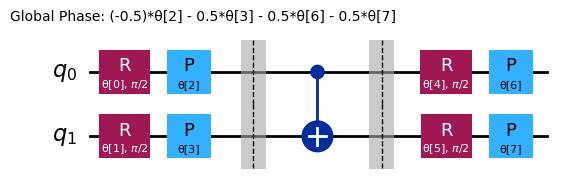

In [15]:
circ_su2 = efficient_su2(num_qubits=2, reps=1, insert_barriers=True)
circ_su2.decompose().draw("mpl")


### b) `z_feature_map` (ZFM)

A phase-based encoding circuit that applies **Hadamard gates** followed by **Z-axis phase rotations**.  
Each repetition layer ($r$) increases the level of entanglement and nonlinearity in the feature space.

For input features $\left(\tfrac{\pi}{2}, \tfrac{\pi}{3}\right)$ with $r = 3$,  
the circuit performs three rounds of phase encoding — effectively capturing higher-order correlations.

This map is commonly used in quantum kernels and variational algorithms,  
where feature phases interfere to form complex, expressive decision boundaries.


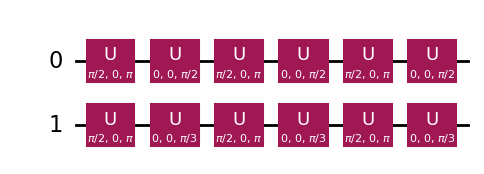

In [16]:
zf = z_feature_map(feature_dimension=2, reps=3)
zf = zf.assign_parameters([(1/2)*pi/2, (1/2)*pi/3])
zf.decompose().draw("mpl")


### c) `zz_feature_map` (ZZFM)

An extension of the ZFM that introduces **two-qubit entangling gates**  
$R_{ZZ}(\theta) = e^{-i\,\theta\,Z\otimes Z/2}$ between qubits.

These ZZ interactions create **correlated phase shifts**,  
allowing the encoding of pairwise relationships between features —  
a key advantage over purely local phase rotations in ZFM.

Because of its entangling nature, ZZFM circuits are believed to be  
**harder to simulate classically** and often yield richer feature spaces.

Below: 2-qubit and 4-qubit examples using linear entanglement topology.


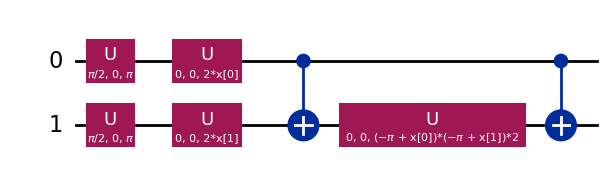

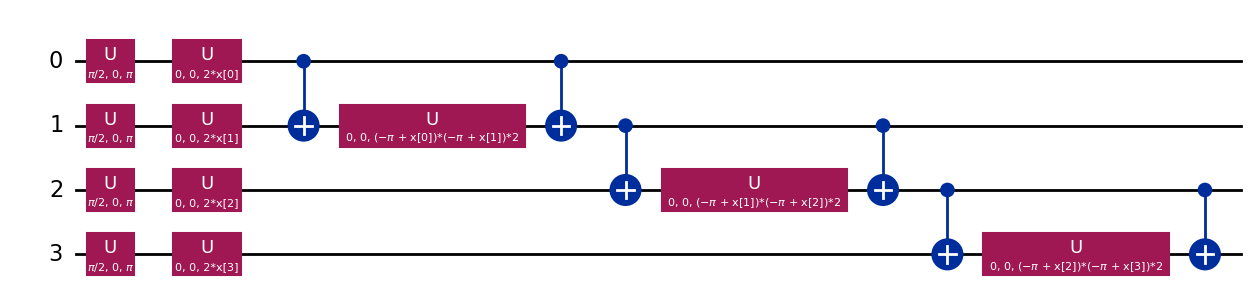

In [20]:
zz2 = zz_feature_map(feature_dimension=2, entanglement="linear", reps=1)
zz4 = zz_feature_map(feature_dimension=4, entanglement="linear", reps=1)

display(zz2.decompose().draw("mpl", scale=1))
zz4.decompose().draw("mpl", scale=1)


### d) `pauli_feature_map` (PFM)

A generalized version of the feature map that allows **arbitrary combinations of Pauli operators**,  
such as `['X', 'Y', 'Z', 'XX', 'YY', 'ZZ']`.

Each Pauli term defines how input features are encoded and entangled across qubits —  
for example, local rotations with `'Y'` and pairwise interactions with `'XX'`.

By selecting different Pauli strings, one can control the circuit’s **expressivity** and  
the **type of correlations** it captures among features.

Below: a small example with Pauli terms `['Y', 'XX']`, demonstrating both single- and two-qubit encodings.


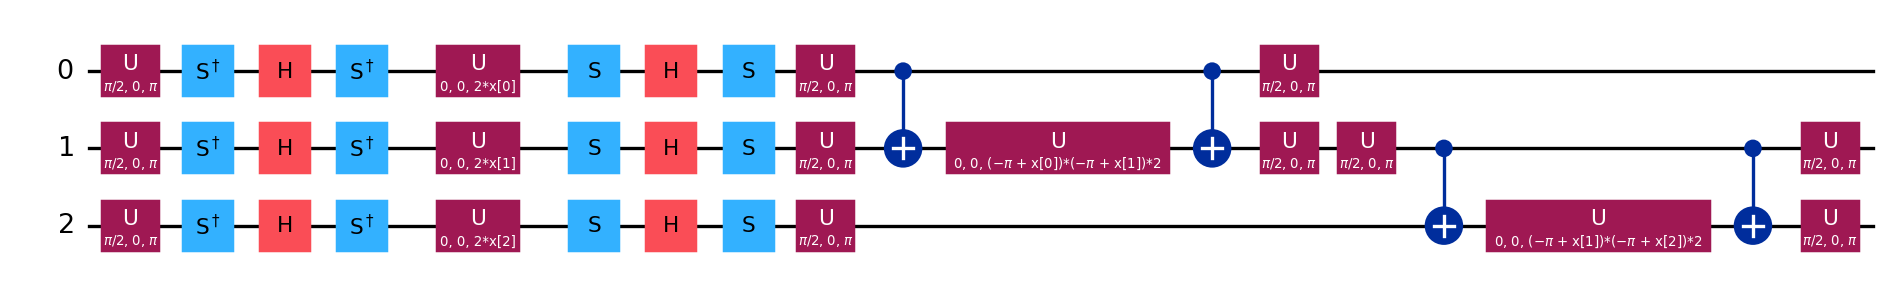

In [21]:
pf = pauli_feature_map(feature_dimension=3, entanglement="linear", reps=1, paulis=["Y","XX"])
pf.decompose().draw("mpl", scale=1.2)


### (Optional) Gallery of Pauli maps (2 qubits)

A quick visualization of how different **Pauli term combinations**  
(`['Z']`, `['ZZ']`, `['X','ZZ']`, etc.) shape the structure of feature maps.

By looping over several configurations, we can observe how each set of  
Pauli operators affects circuit **depth**, **entanglement**, and the resulting  
**feature space geometry**.

This section replicates the lesson’s gallery — useful for comparing encoding behaviors  
across multiple Pauli-based feature maps on 2 qubits.


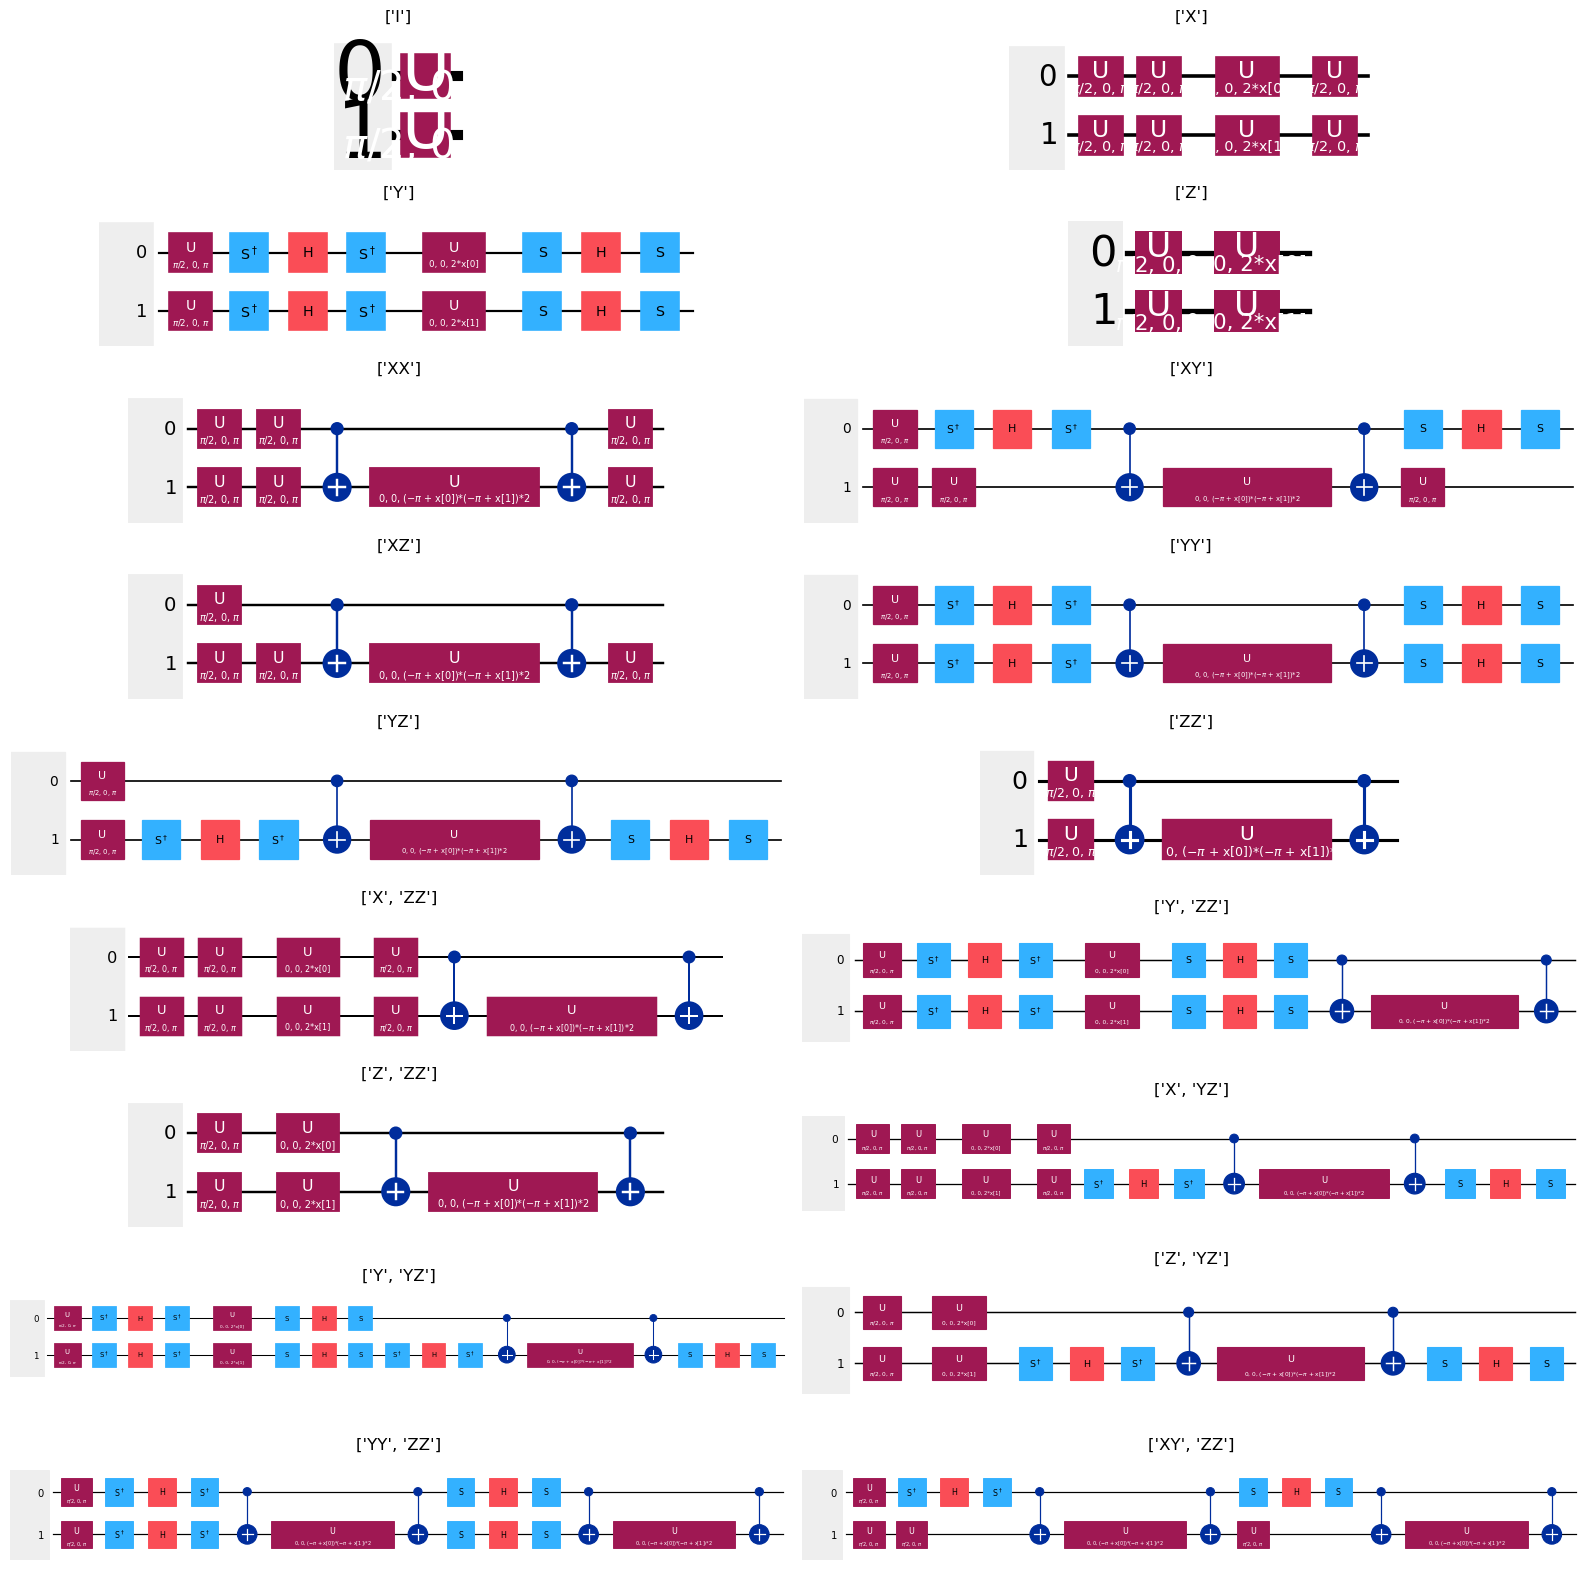

In [22]:
from qiskit.visualization import circuit_drawer

feature_dim = 2
fig, axs = plt.subplots(9, 2, figsize=(16,16))
i_plot = 0
for paulis in [
    ["I"],
    ["X"],
    ["Y"],
    ["Z"],
    ["XX"],
    ["XY"],
    ["XZ"],
    ["YY"],
    ["YZ"],
    ["ZZ"],
    ["X", "ZZ"],
    ["Y", "ZZ"],
    ["Z", "ZZ"],
    ["X", "YZ"],
    ["Y", "YZ"],
    ["Z", "YZ"],
    ["YY", "ZZ"],
    ["XY", "ZZ"],
]:
    pfmap = pauli_feature_map(feature_dimension=feature_dim, paulis=paulis, reps=1)
    circuit_drawer(
        pfmap.decompose(),
        output="mpl",
        style={"backgroundcolor": "#EEEEEE"},
        ax=axs[int((i_plot - i_plot % 2) / 2), i_plot % 2],
    )
    axs[int((i_plot - i_plot % 2) / 2), i_plot % 2].title.set_text(str(paulis))
    i_plot += 1

plt.tight_layout()
plt.show()


## 7) Comparing Two-Qubit Gate Counts

Two-qubit (entangling) gates — such as `CX` — are the main source of **noise and decoherence**  
in today’s quantum hardware.  

To evaluate the practical efficiency of different feature maps,  
we can **decompose** each circuit and count the total number of `cx` gates required.  
This helps compare how encoding choices affect **hardware cost** as we increase  
the number of input features.

Below, we replicate the lesson’s quick benchmark:  
counting `cx` gates for each feature map while scaling feature dimensions.


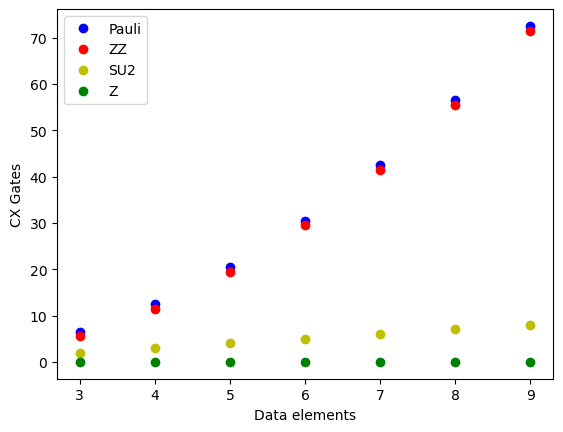

In [18]:
# Initialize parameters and empty lists for depths (from the lesson pattern)
x = [0.1, 0.2]
n_data, zz2gates, su22gates, z2gates, p2gates = [], [], [], [], []

for n in range(3, 10):
    x.append(n / 10)
    zzcircuit = zz_feature_map(n, reps=1, insert_barriers=True)
    zcircuit  = z_feature_map(n, reps=1, insert_barriers=True)
    su2circuit = efficient_su2(n, reps=1, insert_barriers=True)
    pcircuit = pauli_feature_map(n, reps=1, paulis=["XX"], insert_barriers=True)

    zzcx  = zzcircuit.decompose().count_ops().get("cx")
    zcx   = zcircuit.decompose().count_ops().get("cx")
    su2cx = su2circuit.decompose().count_ops().get("cx")
    pcx   = pcircuit.decompose().count_ops().get("cx")

    n_data.append(n)
    zz2gates.append((zzcx or 0) - 0.5)  # small horizontal jitter
    z2gates.append(0 if zcx is None else zcx)
    su22gates.append(0 if su2cx is None else su2cx)
    p2gates.append((pcx or 0) + 0.5)

plt.plot(n_data, p2gates, "bo")
plt.plot(n_data, zz2gates, "ro")
plt.plot(n_data, su22gates, "yo")
plt.plot(n_data, z2gates, "go")
plt.ylabel("CX Gates")
plt.xlabel("Data elements")
plt.legend(["Pauli", "ZZ", "SU2", "Z"])
plt.show()


## 8) Hardware-Efficient Notes

- Real devices have **native gate sets** and **specific coupling maps**.  
  Transpilation automatically inserts `SWAP` gates and decomposes operations to match hardware constraints.  
- To keep circuits reliable on **NISQ** (noisy intermediate-scale quantum) devices:
  - prefer **shallower** encodings,
  - reduce **two-qubit layers** or choose **linear entanglement**,  
  - select a **sub-topology** with longer $T_1/T_2$ times and lower 2-qubit error rates.

In short, circuit **depth and entanglement density** directly influence performance on real hardware.  
Efficient, noise-aware encoding is often more useful than highly expressive but deep circuits.

---

## Wrap-up — Quick Self-Check

1. When would you prefer **amplitude encoding** over **angle/phase encodings**? What trade-off does it involve?  
2. Why is **rescaling to $(0, 2\pi]$** recommended for phase and angle encodings?  
3. In `efficient_su2`, how can a small number of qubits encode many features?

> 💡 Write your short answers in a new Markdown cell below.
